<a href="https://colab.research.google.com/github/ak-boateng/air-quality-index/blob/main/Air_Quality_Index_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Global Air Quality Index (AQI)

## 1. Objective:
Analyze PM2.5 (fine particulate matter) levels across different cities and countries to identify trends, hotspots, and potential environmental or policy influences.

All other information can be found in the documentation in the PDF attached to this repo.

## 2. Data Cleaning & Preprocessing
Here the data set will be imported and cleaned to be ready for the analysis.

In [14]:
!pip install openaq

In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

#libraries to get data
from openaq import OpenAQ
from google.colab import userdata

#library to check missingness in the data
import missingno as msno

In [16]:
# Initialize OpenAQ client
api_key = userdata.get('OPENAQ-API-KEY')  # Make sure this matches your Colab secret name
client = OpenAQ(api_key=api_key)

# Fetch PM2.5 (parameter_id=2) data
locations = client.locations.list(
    parameters_id=2,  # PM2.5
    limit=1000     # Increase limit for more data
)

In [17]:
locations.results[0]

Location(id=3, name='NMA - Nima', locality=None, timezone='Africa/Accra', country=CountryBase(id=152, code='GH', name='Ghana'), owner=OwnerBase(id=4, name='Unknown Governmental Organization'), provider=ProviderBase(id=209, name='Dr. Raphael E. Arku and Colleagues'), is_mobile=False, is_monitor=True, instruments=[InstrumentBase(id=2, name='Government Monitor')], sensors=[SensorBase(id=6, name='pm10 µg/m³', parameter=ParameterBase(id=1, name='pm10', units='µg/m³', display_name='PM10')), SensorBase(id=5, name='pm25 µg/m³', parameter=ParameterBase(id=2, name='pm25', units='µg/m³', display_name='PM2.5'))], coordinates=Coordinates(latitude=5.58389, longitude=-0.19968), bounds=[-0.19968, 5.58389, -0.19968, 5.58389], distance=None, datetime_first=None, datetime_last=None)

In [18]:
# Convert to DataFrame
# Convert locations to DataFrame and extract key information

def process_locations(locations_data):
    processed = []
    for loc in locations_data.results:
        # Extract PM2.5 sensor (check all sensors)
        pm25_sensor = None
        for sensor in loc.sensors:
            if getattr(sensor.parameter, 'id', None) == 2:  # PM2.5 has parameter_id=2
                pm25_sensor = sensor
                break

        if pm25_sensor:  # Only process if PM2.5 sensor exists
            processed.append({
                # Location metadata
                'location_id': loc.id,
                'name': loc.name,
                'country': loc.country.name,
                'country_code': loc.country.code,
                'city': loc.locality,  # May be None
                'latitude': loc.coordinates.latitude,
                'longitude': loc.coordinates.longitude,

                # Sensor info
                'sensor_id': pm25_sensor.id,
                'parameter_name': pm25_sensor.parameter.display_name,
                'units': pm25_sensor.parameter.units,

                # Temporal info
                'first_reading': loc.datetime_first.utc if loc.datetime_first else None,
                'last_reading': loc.datetime_last.utc if loc.datetime_last else None,

                # Additional metadata
                'is_mobile': loc.is_mobile,
                'provider': loc.provider.name
            })
    return pd.DataFrame(processed)

# Usage
locations_df = process_locations(locations)
print(f"Found {len(locations_df)} PM2.5 monitoring stations")
print(locations_df.head())

Found 1000 PM2.5 monitoring stations
   location_id                 name country country_code  city  latitude  \
0            3           NMA - Nima   Ghana           GH  None  5.583890   
1            4           NMT - Nima   Ghana           GH  None  5.581650   
2            5      JTA - Jamestown   Ghana           GH  None  5.540114   
3            6    ADT - Asylum Down   Ghana           GH  None  5.570722   
4            7  ADEPA - Asylum Down   Ghana           GH  None  5.567833   

   longitude  sensor_id parameter_name  units first_reading last_reading  \
0  -0.199680          5          PM2.5  µg/m³          None         None   
1  -0.198980          8          PM2.5  µg/m³          None         None   
2  -0.210397          9          PM2.5  µg/m³          None         None   
3  -0.212056         12          PM2.5  µg/m³          None         None   
4  -0.204028         13          PM2.5  µg/m³          None         None   

   is_mobile                            provider 

In [19]:
#Check for the entire data(ie total rows and columns) in the dataset
locations_df.shape

(1000, 14)

## Detecting missing data visually using Missingno library
Here I check for the missing values, reason for the missingness, and how to deal with them. To graphically analyse the missingness of the data, I used a library called Missingno It is a package for graphical analysis of missing values. To use this library, I imported it as follows: import missingno as msno

<Axes: >

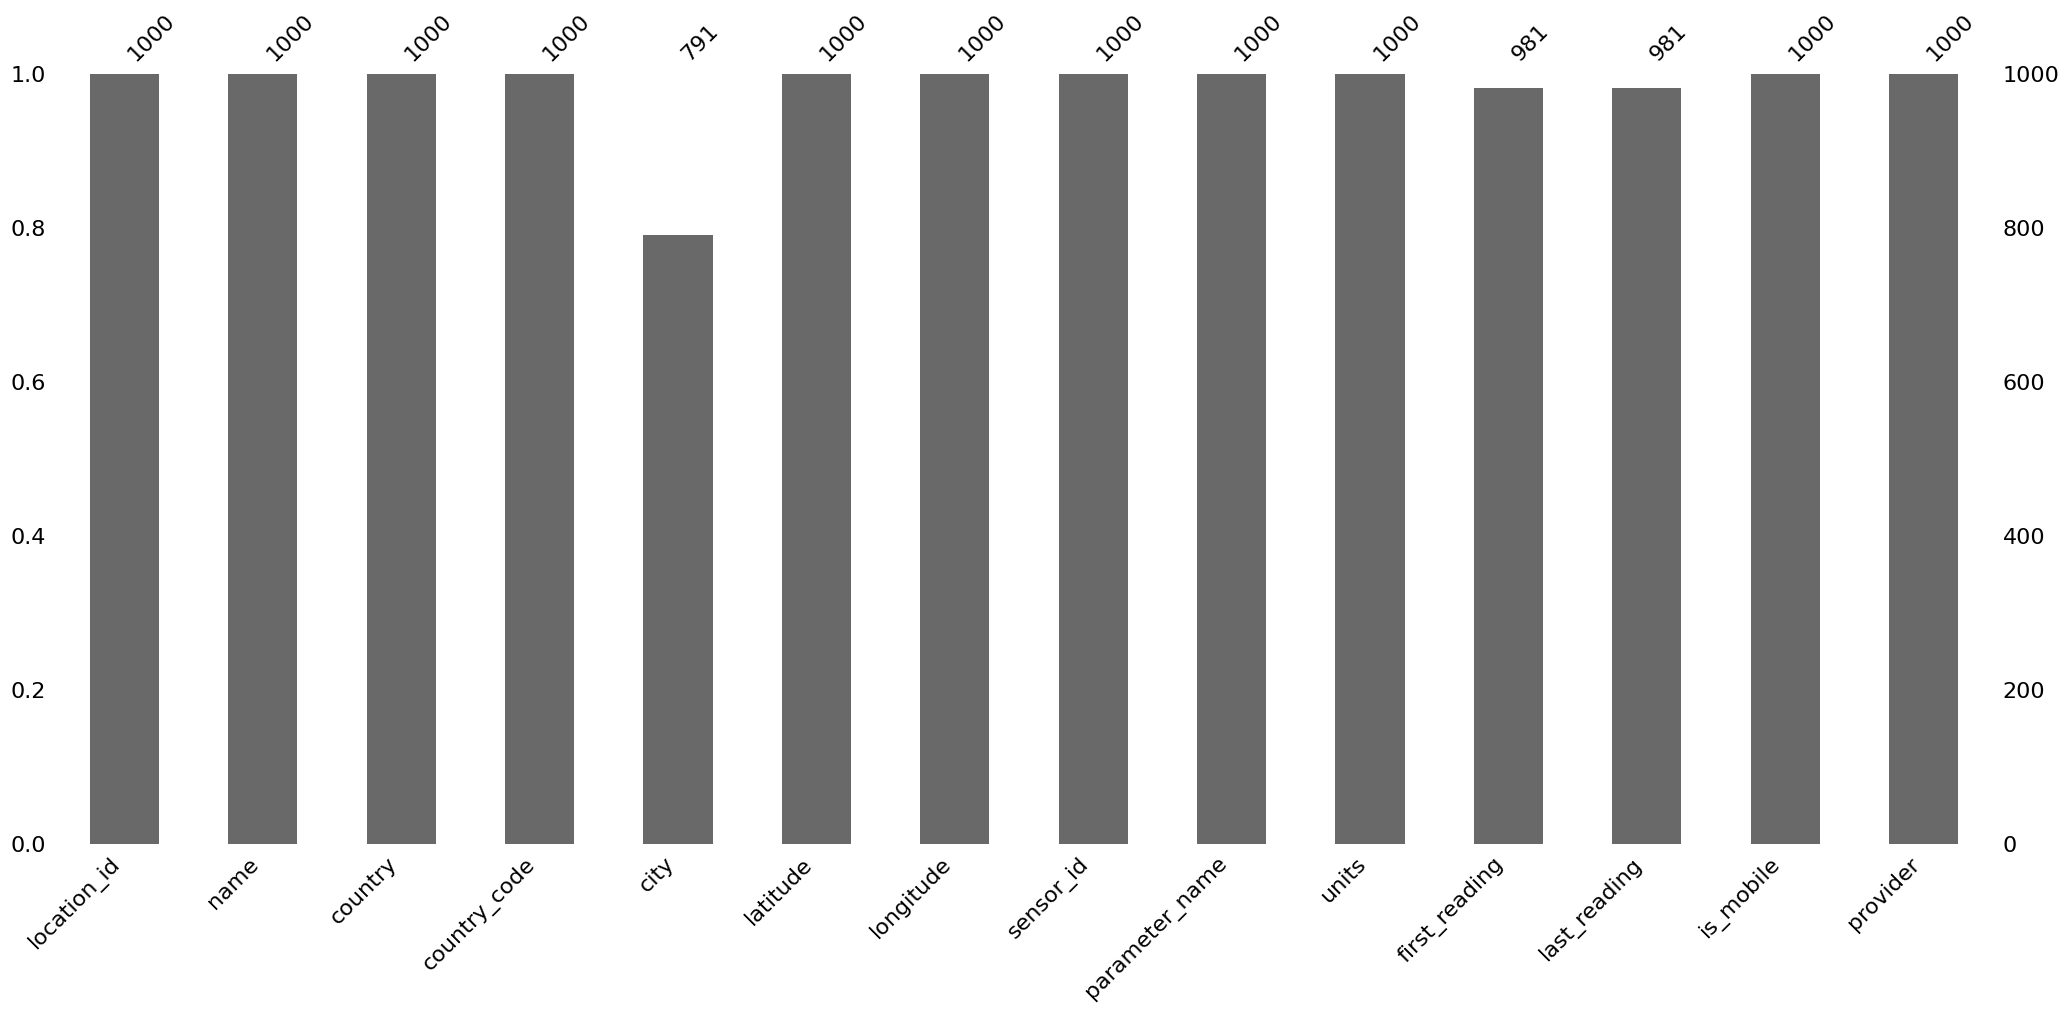

In [20]:
msno.bar(locations_df)

<Axes: >

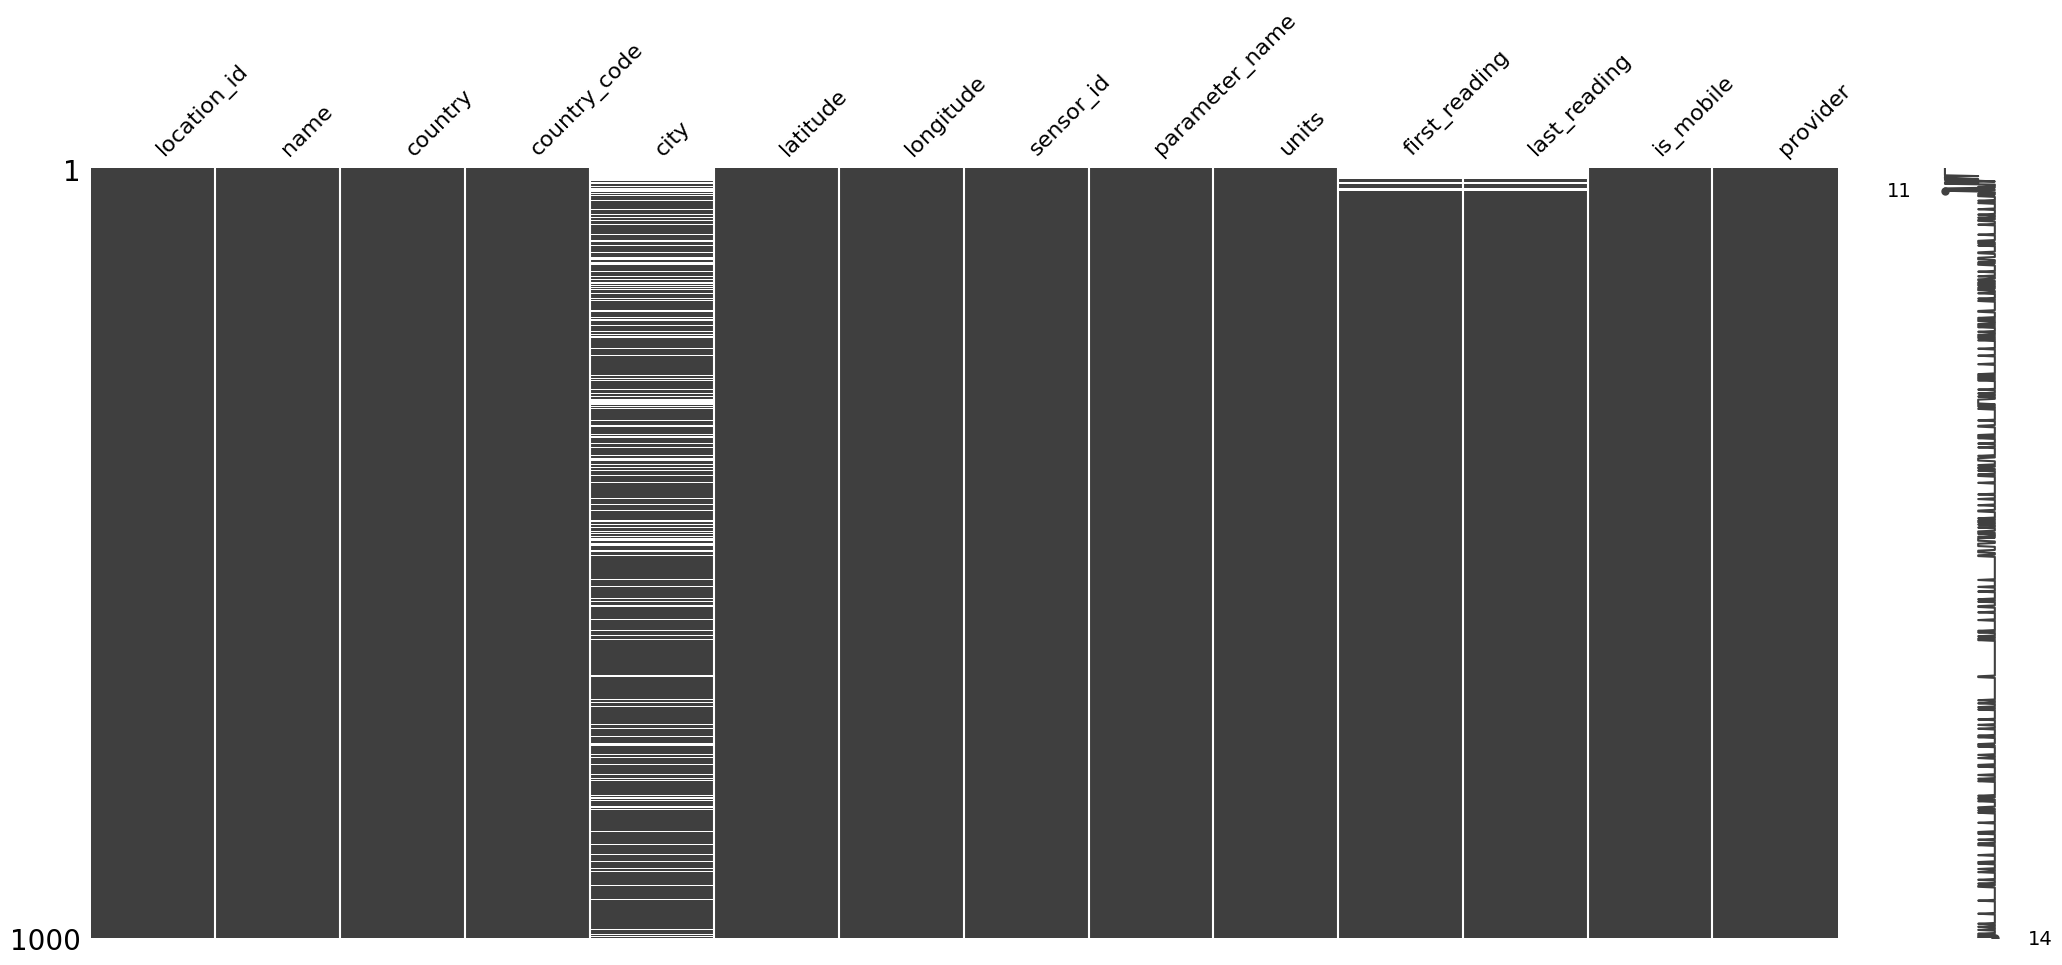

In [21]:
#Here viewing as a matrix shows me how they are missing in the data


msno.matrix(locations_df)

<Axes: >

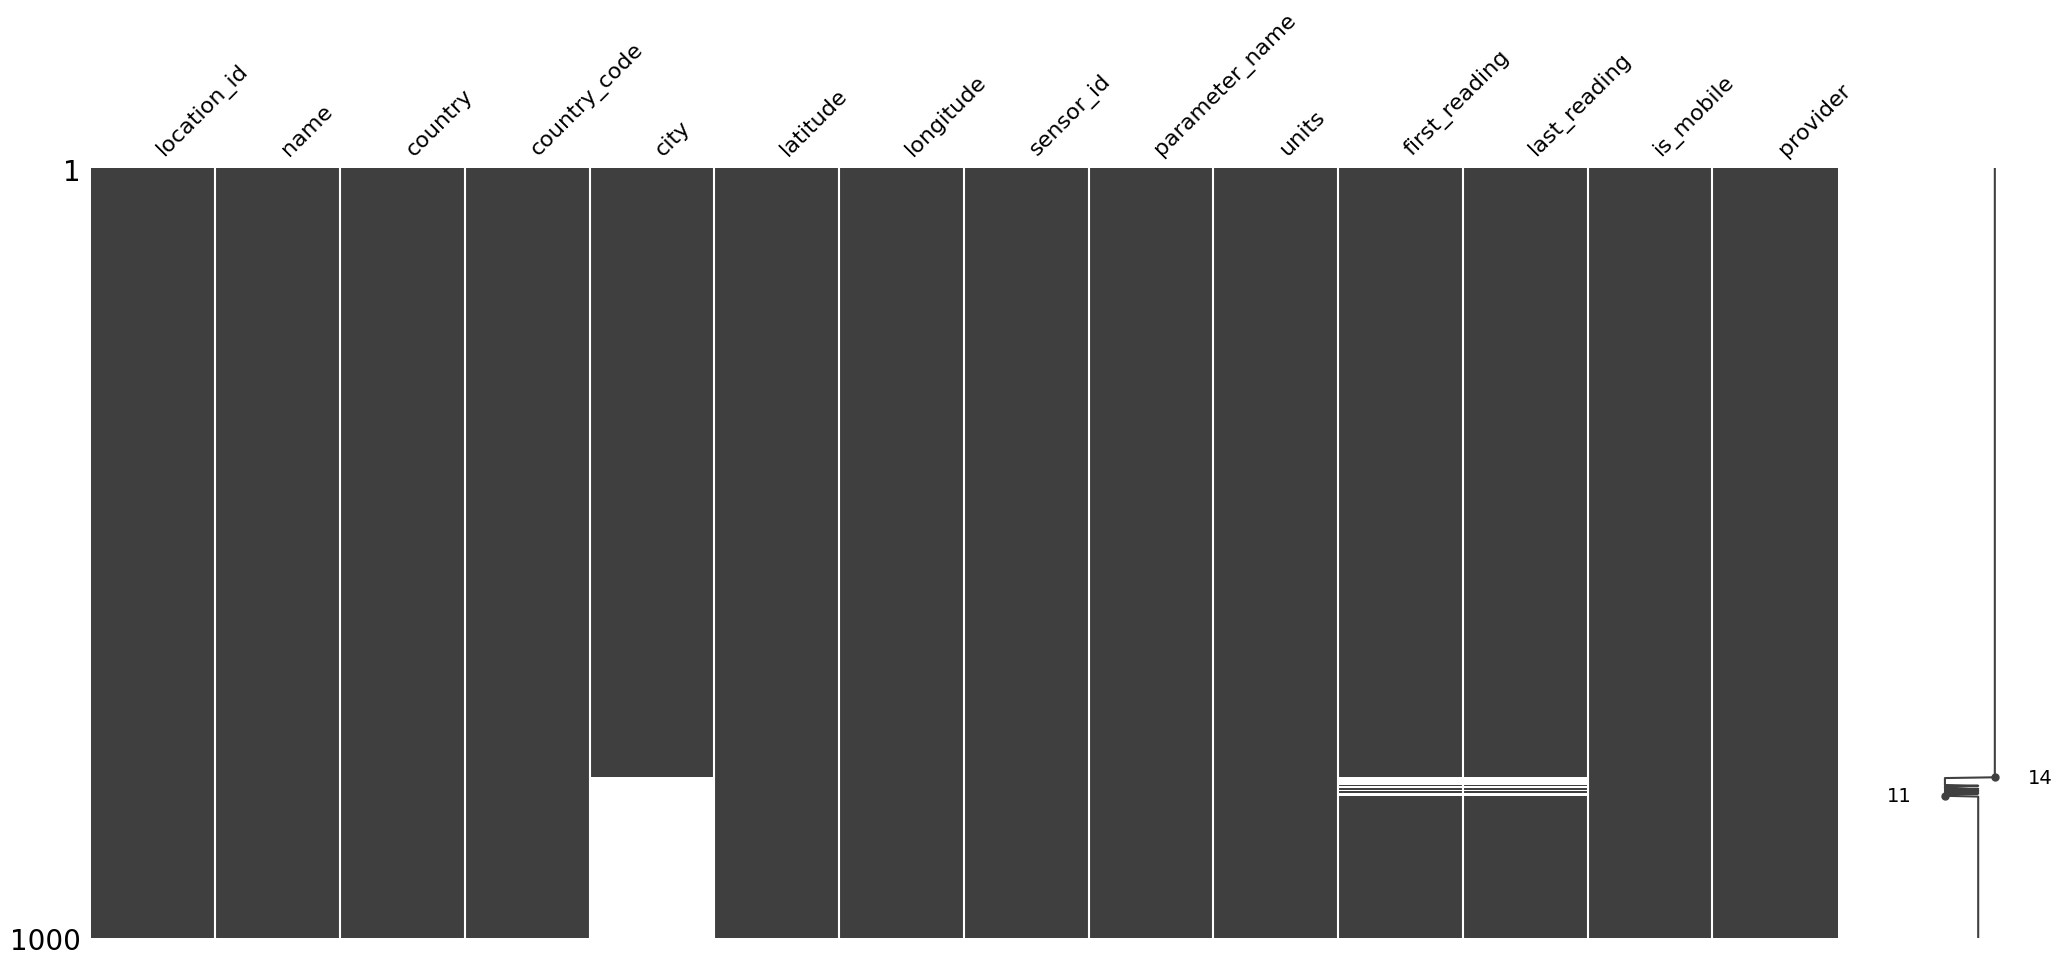

In [22]:
#Sort data according to city just to see if there is some connecttion between the city values and their corresponding first and last readings.

sorted = locations_df.sort_values('city')
msno.matrix(sorted)

## Reasons for Missing Values
Before we start treating the missing values ,it is important to understand the various reasons for the missingness in data.


From the visual above it can be seen that there is some sort of correspondence between the values for the city and that of missing values for first and last readings.

Additionally, at a glance, the missing values in city column can be classified as MAR(Missing At Random) and that of the readings as (MCAR)Missing Completely at Random. Read More [Here](https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python#Reasons-for-Missing-Values)


Next is that I am going to test or confirm the reasons for the missingness, and then choose how to treat the missing values.

In [24]:
# Create missingness indicator
locations_df['reading_missing'] = locations_df['last_reading'].isnull()
# Compare means of other variables
for col in ['latitude', 'longitude', 'is_mobile']:
    present = locations_df[~locations_df['reading_missing']][col]
    missing = locations_df[locations_df['reading_missing']][col]
    t_stat, p_val = ttest_ind(present, missing, nan_policy='omit')
    print(f"{col}: p={p_val:.3f}")  # p > 0.05 suggests MCAR

latitude: p=0.000
longitude: p=0.000
is_mobile: p=nan
